In [1]:
import numpy as np


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import cv2
import numpy as np
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch
from transformers.utils import logging
logging.set_verbosity_info()


In [4]:
# Load model & processor
#use base instead of small if bad accuracy irl
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')


loading configuration file preprocessor_config.json from cache at C:\Users\mahmoud\.cache\huggingface\hub\models--microsoft--trocr-small-handwritten\snapshots\b4648cfa171985a6745f37ddd637e98c0da958ac\preprocessor_config.json
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 384. Converted to {'height': 384, 'width': 384}.
crop_size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}, {'longest_edge'}, {'max_width', 'max_height'}), got 224. Converted to {'height': 224, 'width': 224}.
Image processor DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image

In [103]:

class BubbleSheetProcessor:
    def __init__(self, image_path):
        self.image_path = image_path
        self.nc = None
        self.row_threshold=10
        self.image = None
        self.gray = None
        self.warped = None
        self.cropped = None
        self.thresh = None
        self.bubble_contours = None
        self.answer_matrix = None
        self.student_id=None
        self.bubbles_area_x, self.bubbles_area_y, self.bubbles_area_w, self.bubbles_area_h=None,None,None,None
        self.marker_area=None

    def load_image(self):
        self.image = cv2.imread(self.image_path)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)

    def get_id_corner_map(self):
        aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_100)
        parameters = cv2.aruco.DetectorParameters()
        detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

        corners, ids, _ = detector.detectMarkers(self.gray)
        if ids is None or len(ids) < 4:
            raise ValueError("Not all 4 ArUco markers were detected.")

        id_corner_map = {id[0]: corner for id, corner in zip(ids, corners)}

        if 48 in id_corner_map:
            self.nc = 5
        elif 49 in id_corner_map:
            self.nc = 4
        else:
            raise ValueError("Required ArUco marker not found.")
        #give the area of a circle with diameter equals to the edge of a marker
        marker_arr=id_corner_map[30]
        self.marker_area=np.pi*(int(abs(marker_arr[0][1][0]-marker_arr[0][0][0]))/2)**2
        return id_corner_map

    def get_center(self, corner):
        return corner[0].mean(axis=0)

    def get_centroid(self, array):
        return np.array(array).mean(axis=0)

    def get_roi(self, id_corner_map):
        if 48 in id_corner_map:
            ordered_ids = [30, 10, 48, 34]  # TL, TR, BR, BL
        else:  # 49 is guaranteed if 48 isn't
            ordered_ids = [30, 10, 49, 34]

        ordered_pts = [self.get_center(id_corner_map[id]) for id in ordered_ids]
        return np.array(ordered_pts, dtype='float32')

    def get_warped_image(self, src_pts):
        width, height = int(self.image.shape[0] * 0.764), self.image.shape[0]
        dst_pts = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype='float32')

        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        return cv2.warpPerspective(self.image, M, (width, height))

    def get_largest_contour(self, image, drawContour=False):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(
            gray, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 
            25, 4
        )
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        largest_contour = max(contours, key=cv2.contourArea)

        if drawContour:
            cv2.drawContours(image, largest_contour, -1, (0, 255, 0), 3)
            cv2.imshow('largest contour', image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        return largest_contour
    
    def warp_paper(self):
        id_corner_map = self.get_id_corner_map()
        roi = self.get_roi(id_corner_map)
        self.warped = self.get_warped_image(roi)

    def preprocess_cropped(self,debug=False):
        self.bubbles_area_x, self.bubbles_area_y, self.bubbles_area_w, self.bubbles_area_h = cv2.boundingRect(self.get_largest_contour(self.warped))
        self.cropped = self.warped[self.bubbles_area_y+10:self.bubbles_area_y+self.bubbles_area_h-10, 
                                    self.bubbles_area_x+10:self.bubbles_area_x+self.bubbles_area_w-10]
        
        cropped_gray = cv2.cvtColor(self.cropped, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(cropped_gray, (3, 3), 0)

        self.thresh = cv2.adaptiveThreshold(
            blurred, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 
            57, 4
        )
        if debug==True:
            print("self.thresh")
            plt.imshow(self.thresh,cmap='gray')

    def extract_bubble_contours(self, debug=False):
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        bubble_contours = []
        
        # Filter bubble contours as before
        for c in contours:
            area = cv2.contourArea(c)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = w / float(h)
        
            if area > self.marker_area and 0.9 < aspect_ratio < 1.1:
                bubble_contours.append(c)
        
        # First sort all bubbles by their y-coordinate (top to bottom)
        bubble_contours.sort(key=lambda b: self.get_centroid(b)[0][1])
        
        # Group bubbles into rows based on y-coordinate proximity
        if not bubble_contours:
            return []  # no bubbles found
        
        rows = []
        current_row = [bubble_contours[0]]
        y_centroid = self.get_centroid(bubble_contours[0])[0][1]
        
        for b in bubble_contours[1:]:
            current_y = self.get_centroid(b)[0][1]
            # If y-coordinate is close enough to current row, add to same row
            if abs(current_y - y_centroid) < self.row_threshold:  # adjust threshold as needed
                current_row.append(b)
            else:
                # Sort current row by x-coordinate and add to rows
                current_row.sort(key=lambda b: self.get_centroid(b)[0][0])
                rows.append(current_row)
                # Start new row
                current_row = [b]
                y_centroid = current_y
        
        # Add the last row
        if current_row:
            current_row.sort(key=lambda b: self.get_centroid(b)[0][0])
            rows.append(current_row)
        
        # Flatten the rows back into a single list
        sorted_bubbles = [bubble for row in rows for bubble in row]


        if debug:
            output = self.cropped.copy()
            cv2.drawContours(output, bubble_contours, -1, (0, 255, 0), 2)
            plt.imshow(output)

        self.bubble_contours = sorted_bubbles

    def get_filled_bubbles_matrix(self):
        extracted = []

        for c in self.bubble_contours:
            mask = np.zeros(self.thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            masked = cv2.bitwise_and(self.thresh, self.thresh, mask=mask)

            total = cv2.countNonZero(mask)
            filled = cv2.countNonZero(masked)
            ratio = filled / total

            extracted.append(1 if ratio > 0.5 else 0)

        self.answer_matrix = np.array(extracted).reshape(-1, self.nc)
    def detect_student_id(self,drawContours=False):
        id_area=self.warped[0:self.bubbles_area_y, int(self.warped.shape[1]*.75):]
        x, y, w, h = cv2.boundingRect(self.get_largest_contour(id_area))
        
        student_id_img=id_area[y+5:y+h-5, x+5:x+w-5]
        
        pixel_values = processor(images=student_id_img, return_tensors="pt").pixel_values
        # Run inference
        generated_ids = model.generate(pixel_values,max_length=14,min_length=4,num_beams =2,early_stopping =True,repetition_penalty=.8)
        student_id = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        self.student_id=re.sub(r'\D', '', student_id)
        if drawContours:
            output = id_area.copy()
            cv2.drawContours(output, self.get_largest_contour(id_area), -1, (0, 255, 0), 2)
            output_resized = cv2.resize(output, (800, int(output.shape[0] * 800 / output.shape[1])))
            cv2.imshow('Detected Bubbles', output_resized)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        
    
    def run_pipeline(self):
        self.load_image()
        self.warp_paper()
        self.preprocess_cropped()
        self.extract_bubble_contours()
        self.get_filled_bubbles_matrix()
        self.detect_student_id()
        return self.student_id, self.answer_matrix


In [106]:
import time
s=time.time()
sheet_processor=BubbleSheetProcessor('Downloads/model.jpg')
print(sheet_processor.run_pipeline())
print(time.time()-s)

('31415', array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]]))
1.292067527770996


In [107]:
def get_results(model_answer_image, *students_answers_images):
    processor=BubbleSheetProcessor(model_answer_image)
    _,mam=processor.run_pipeline()
    
    for student_answer in students_answers_images:
        processor=BubbleSheetProcessor(student_answer)
        student_id,sam=processor.run_pipeline()
        sam==mam
        print(student_id,np.all(sam==mam,axis=1).sum())
        
    

In [109]:
get_results('Downloads/model.jpg','Downloads/model.jpg','Downloads/model.jpg')

31415 33
31415 33


In [270]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import pandas as pd


In [1867]:


# Helper function to generate a believable answer
def generate_student_answer(model,num_questions, num_choices,accuracy=0.6):
    answer = np.zeros_like(model)
    for i in range(num_questions):
        if np.random.rand() < accuracy:
            correct_choice = np.argmax(model[i])
        else:
            # Wrong answer, choose randomly excluding the correct one
            choices = list(set(range(num_choices)) - {np.argmax(model[i])})
            correct_choice = np.random.choice(choices)
        answer[i, correct_choice] = 1
    return answer

def simulate_answers(num_students,num_cheaters,num_questions,num_choices,student_mean_acc,cheater_mean_acc):
    # Create model answer (the "correct" one)
    model = np.zeros((num_questions, num_choices), dtype=int)
    for i in range(num_questions):
        model[i, i % num_choices] = 1

    # Generate student accuracies using normal distribution
    student_accuracies = np.clip(np.random.normal(student_mean_acc, 0.1, size=num_students), 0.3, 0.9)
    # Generate regular student answers
    students = [generate_student_answer(model,num_questions,num_choices, accuracy=acc) for acc in student_accuracies]
    # Create cheater base with a higher mean accuracy
    cheater_accuracy = np.clip(np.random.normal(cheater_mean_acc, 0.05), 0.65, 0.85)
    cheater_base = generate_student_answer(model,num_questions,num_choices, accuracy=cheater_accuracy)
    # Create n cheaters from the base with slight variations
    cheaters = []
    for i in range(num_cheaters):
        cheater = cheater_base.copy()
        # Introduce a small chance of changing a few answers for realism
        for j in range(num_questions):
            if np.random.rand() < 0.1:  # 10% chance to change
                cheater[j] = np.zeros(num_choices)
                cheater[j, np.random.randint(0, num_choices)] = 1
        cheaters.append(cheater)
    
    # Combine all students and cheaters
    students.extend(cheaters)

    return model,students
    
model,students=simulate_answers(num_students=20,num_cheaters=2,num_questions=33,num_choices=4,student_mean_acc=.8,cheater_mean_acc=.8)





In [1868]:
import numpy as np
from typing import List, Dict, Tuple
from scipy.special import comb

def prob_matching_wrong_answers(k, m, n, c, accuracy,alpha=.01):
    '''
    calculates probability that at least there is one pair with k identical wrong answers 
    '''
    p_0= round(((1-accuracy)**2)/(c-1),5)
    # Calculate the binomial probability
    binomial_prob = comb(n, k) * (p_0**k) * ((1-p_0)**(n-k))
    # Calculate the final probability
    p_value = 1 - (1 - binomial_prob)**comb(m, 2)
    if p_value <alpha:
        significance='statistically significant ✅'
    else:
        significance='statistically insignificant ❌'
    return p_value,significance


def count_same_wrong_answers_vectorized(
    model: np.ndarray, 
    students: List[np.ndarray], 
    top_n: int = 5
) -> List[Tuple[Tuple[int, int], int]]:
    """
    Vectorized implementation to count same wrong answers between all student pairs.
    
    Args:
        model: Correct answer matrix (num_questions × num_choices)
        students: List of student answer matrices
        top_n: Number of top pairs to return
        
    Returns:
        List of tuples containing ((student_i, student_j), count) sorted by count in descending order
    """
    # Convert model and student answers to choice indices (num_students × num_questions)
    correct_choices = np.argmax(model, axis=1)  # (num_questions,)
    student_choices = np.array([np.argmax(s, axis=1) for s in students])  # (num_students × num_questions)
    
    # Create mask of wrong answers for each student (num_students × num_questions)
    wrong_mask = student_choices != correct_choices
    
    # Prepare for pairwise comparisons
    n_students = len(students)
    indices = np.triu_indices(n_students, k=1)  # Upper triangle indices excluding diagonal
    
    # Vectorized computation of same wrong answers
    s1, s2 = indices
    both_wrong = wrong_mask[s1] & wrong_mask[s2]  # Where both got it wrong
    same_wrong = (student_choices[s1] == student_choices[s2]) & both_wrong
    
    # Count same wrong answers per pair
    counts = np.sum(same_wrong, axis=1)
    
    # Create result pairs with counts
    pairs = list(zip(zip(s1, s2), counts))
    
    # Sort by count descending and return top_n
    top_pairs = sorted(pairs, key=lambda x: -x[1])[:top_n]
    
    return top_pairs

scores = np.array([np.sum(np.all(student == model, axis=1)) for student in students])
n_choices=students[0].shape[1]
n_questions=students[0].shape[0]
n_students=len(students)
accuracy=np.median(scores)/n_questions
# Get top 5 suspicious pairs
top_pairs = count_same_wrong_answers_vectorized(model, students, top_n=5)
for (i, j), count in top_pairs:
    p,significance=prob_matching_wrong_answers(k=count, m=n_students, n=n_questions, c=n_choices, accuracy=accuracy,alpha=.001)
    print(f"Students {i} and {j} have {count} identical wrong answers | p ={p}  {significance}")

Students 20 and 21 have 7 identical wrong answers | p =0.0006530538027290644  statistically significant ✅
Students 0 and 6 have 3 identical wrong answers | p =0.9949786577711071  statistically insignificant ❌
Students 2 and 20 have 3 identical wrong answers | p =0.9949786577711071  statistically insignificant ❌
Students 6 and 15 have 3 identical wrong answers | p =0.9949786577711071  statistically insignificant ❌
Students 7 and 11 have 3 identical wrong answers | p =0.9949786577711071  statistically insignificant ❌


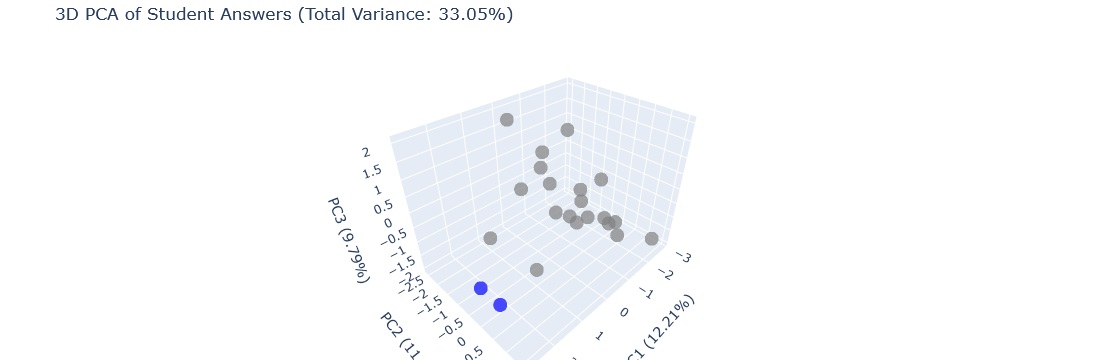

Variance explained by each principal component:
PC1: 12.21%
PC2: 11.05%
PC3: 9.79%
Total variance explained by first 3 PCs: 33.05%


In [1869]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
X = np.array([student.flatten() for student in students])
clustering = DBSCAN(eps=.1, min_samples=2,metric='hamming').fit(X)
#clustering = HDBSCAN(min_cluster_size=2,metric='hamming').fit(X)
labels = clustering.labels_

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_
total_variance = sum(explained_variance)

centroid = np.median(X_pca, axis=0).reshape(1, -1)
distances = cdist(X_pca, centroid, metric='euclidean').flatten()
normalized_distances = (distances - np.mean(distances)) / np.std(distances)

std_dev = np.std(normalized_distances)
distance_threshold = np.mean(normalized_distances) + 2 * std_dev
outliers_mask = distances > distance_threshold
labels=np.where(outliers_mask==True,labels,-1)

student_ids = [f"Student {i}" for i in range(len(students))]

colors_scheme=['red','blue','green','gray']
colors=[]
for L in labels:
    colors.append(colors_scheme[L])
    

# Convert to DataFrame for plotly
df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'Student_ID': student_ids,
    'Score': scores,
    'Color': colors
})

# Create interactive 3D plot with Plotly
fig = go.Figure()

# Add all students as scatter points
fig.add_trace(go.Scatter3d(
    x=df['PC1'],
    y=df['PC2'],
    z=df['PC3'],
    mode='markers',
    marker=dict(
        size=8,
        color=df['Color'],
        opacity=0.7
    ),
    text=df['Student_ID'],
    hovertemplate=
    '<b>%{text}</b><br>' +
    'Score: %{customdata[0]}<br>' +
    'PC1: %{x:.2f}<br>' +
    'PC2: %{y:.2f}<br>' +
    'PC3: %{z:.2f}',
    customdata=np.stack((df['Score'],), axis=-1)
))

# Update the layout
fig.update_layout(
    title=f'3D PCA of Student Answers (Total Variance: {total_variance:.2%})',
    scene=dict(
        xaxis_title=f'PC1 ({explained_variance[0]:.2%})',
        yaxis_title=f'PC2 ({explained_variance[1]:.2%})',
        zaxis_title=f'PC3 ({explained_variance[2]:.2%})',
    ),
    font=dict(size=12),
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=False
)

# Show the figure
fig.show()

# Print variance explained
print("Variance explained by each principal component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.2%}")
print(f"Total variance explained by first 3 PCs: {total_variance:.2%}")

# For environments that can't display interactive plotly plots,
# save as HTML file that can be opened in any browser
fig.write_html("pca_visualization_3d.html")


In [1870]:
model

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])